In [4]:
import os
import sys
import copy
import glob
import time
import shutil
import gc

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq


from tqdm.auto import tqdm


In [5]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

'0.18.0'

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

In [7]:
oracle = co.load_hdf5("/mnt/c/users/UVictor/Documents/CellOracle/Shim22/PreKnockOut_data_Shim22_GreenleafGRN.celloracle.oracle")

In [8]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 7550
    n_genes: 3011
    cluster_name: FineClust
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 20169 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 129 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2664 genes
    k_for_knn_imputation: 553
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [9]:
regulatory_genes = oracle.active_regulatory_genes
print(regulatory_genes)

['AHR', 'ARHGEF12', 'ASCL2', 'ATF3', 'ATF6B', 'BACH2', 'BARX1', 'BBX', 'BCL11A', 'BCL11B', 'BCL6', 'BHLHE22', 'BHLHE40', 'BHLHE41', 'BRCA1', 'CCDC6', 'CDC5L', 'CEBPA', 'CEBPD', 'CEBPG', 'CREBZF', 'CTCF', 'CUX1', 'DLX1', 'DLX2', 'E2F1', 'E2F3', 'E2F7', 'EGR2', 'EGR4', 'EHF', 'ELF3', 'EN1', 'EP300', 'ETS2', 'ETV4', 'ETV5', 'EZH2', 'FOSB', 'FOSL1', 'FOXC1', 'FOXE1', 'FOXI3', 'FOXM1', 'FOXN1', 'FOXN3', 'FOXQ1', 'FOXS1', 'FUBP1', 'GATA3', 'GLI3', 'HERPUD1', 'HES2', 'HES5', 'HIF1A', 'HMGA2', 'HOXA9', 'HOXD8', 'IRF1', 'IRX1', 'IRX3', 'IRX4', 'IRX5', 'JUN', 'JUNB', 'KLF10', 'KLF13', 'KLF2', 'KLF6', 'LEF1', 'LMO2', 'MAFB', 'MAFF', 'MEIS2', 'MITF', 'MSX1', 'MSX2', 'MYB', 'MYBL2', 'MYCN', 'NFE2L1', 'NFYB', 'NR2E1', 'NR4A1', 'NR4A2', 'ONECUT2', 'ONECUT3', 'OVOL1', 'PBX1', 'PITX1', 'POLR2A', 'POU2F2', 'POU3F1', 'POU4F1', 'PPARG', 'RARG', 'RORA', 'RUNX3', 'SALL4', 'SMARCC2', 'SOX21', 'SOX7', 'SP6', 'STAT1', 'STAT2', 'STAT3', 'STAT4', 'STAT5A', 'STAT5B', 'STAT6', 'TBX1', 'TBX3', 'TCF3', 'TCF7L2', 'TF

In [10]:
print(dir(oracle))

['GRN_unit', 'TFdict', '_Oracle__simulate_shift', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calculate_potential_OOD_exceedance_ratio', '_clear_simulation_results', '_generate_meta_data', '_plot_one_trajectory', '_process_TFdict_metadata', 'active_regulatory_genes', 'adata', 'addTFinfo_dictionary', 'all_regulatory_genes_in_TFdict', 'all_target_genes_in_TFdict', 'alpha_for_trajectory_GRN', 'calculate_embedding_shift', 'calculate_grid_arrows', 'calculate_mass_filter', 'calculate_p_mass', 'calculate_randomized_coef_table', 'celloracle_version_used', 'change_cluster_unit', 'clip_delta_X', 'cluster_column_name', 'cluster_specific_TFdict', 'coef_matrix_per_cluster', 'colorandum', 'copy', 'count

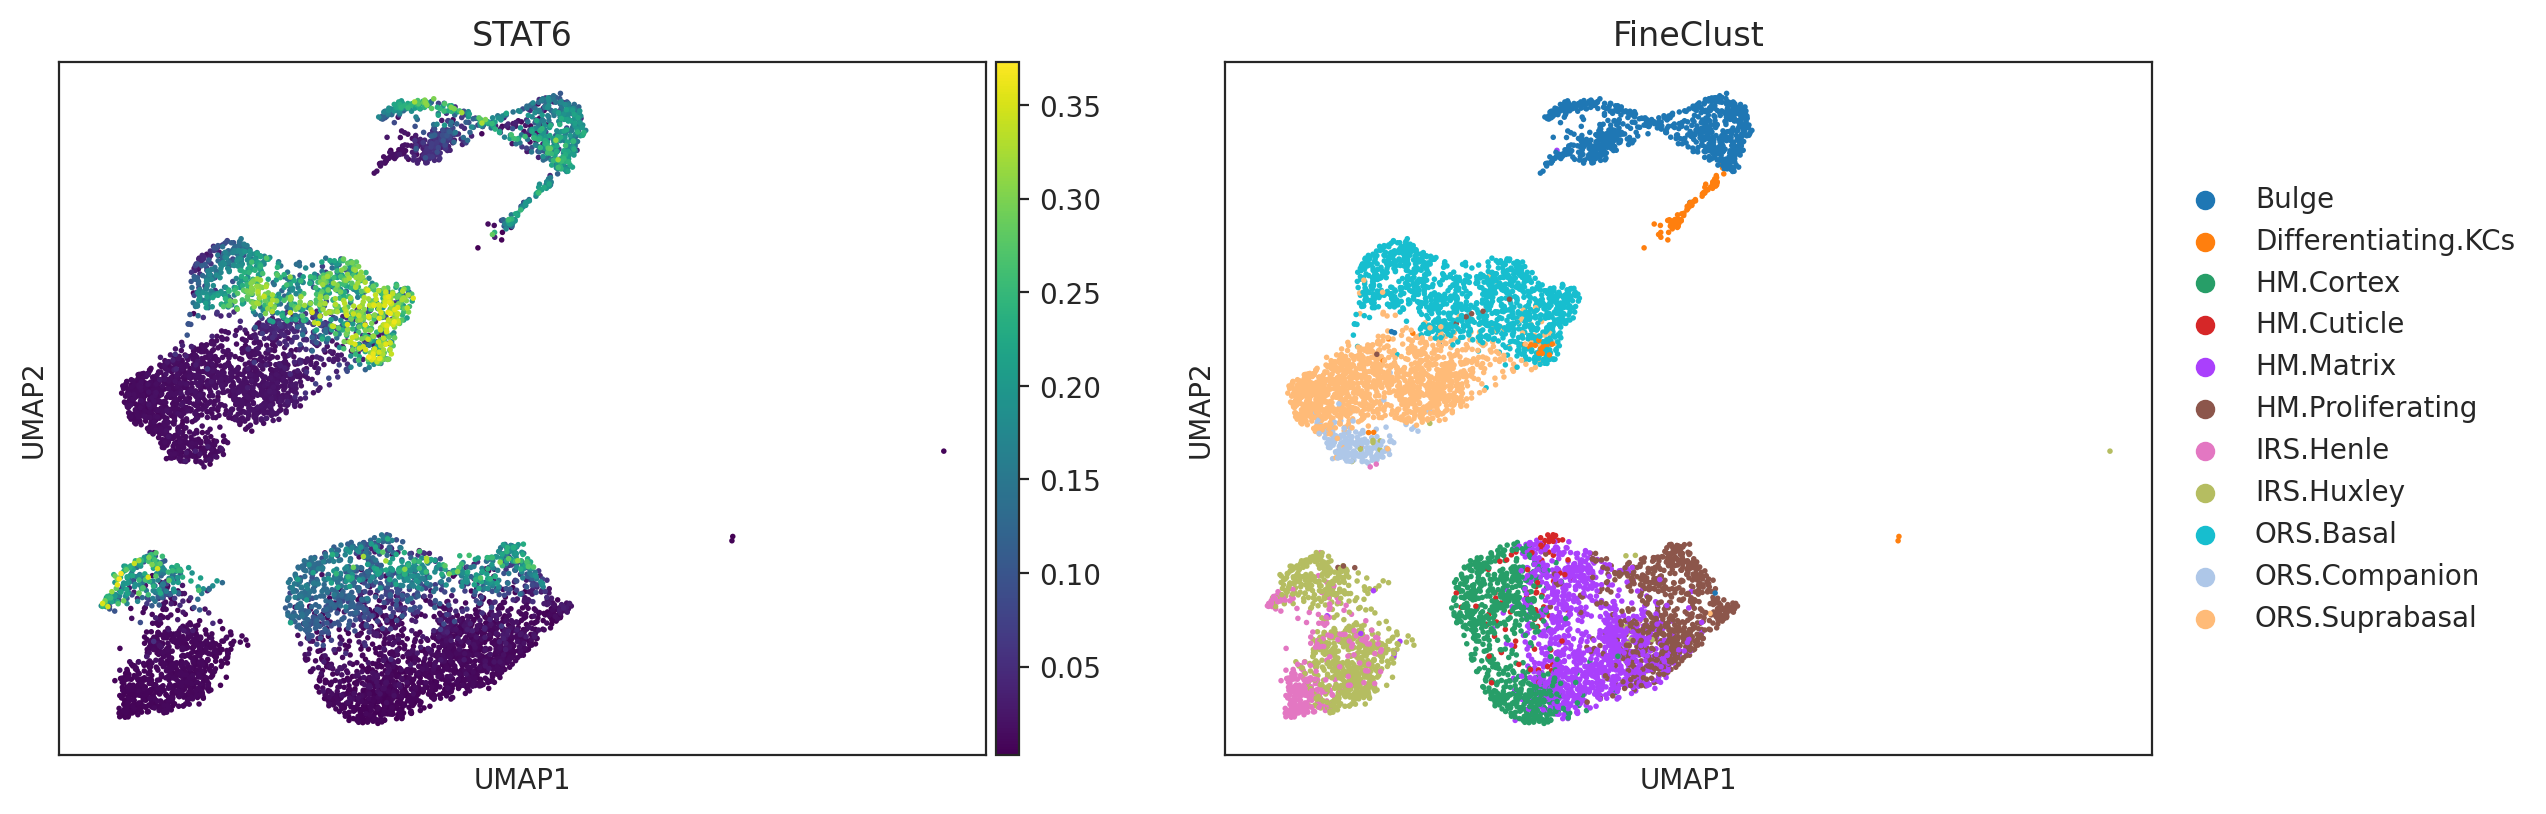

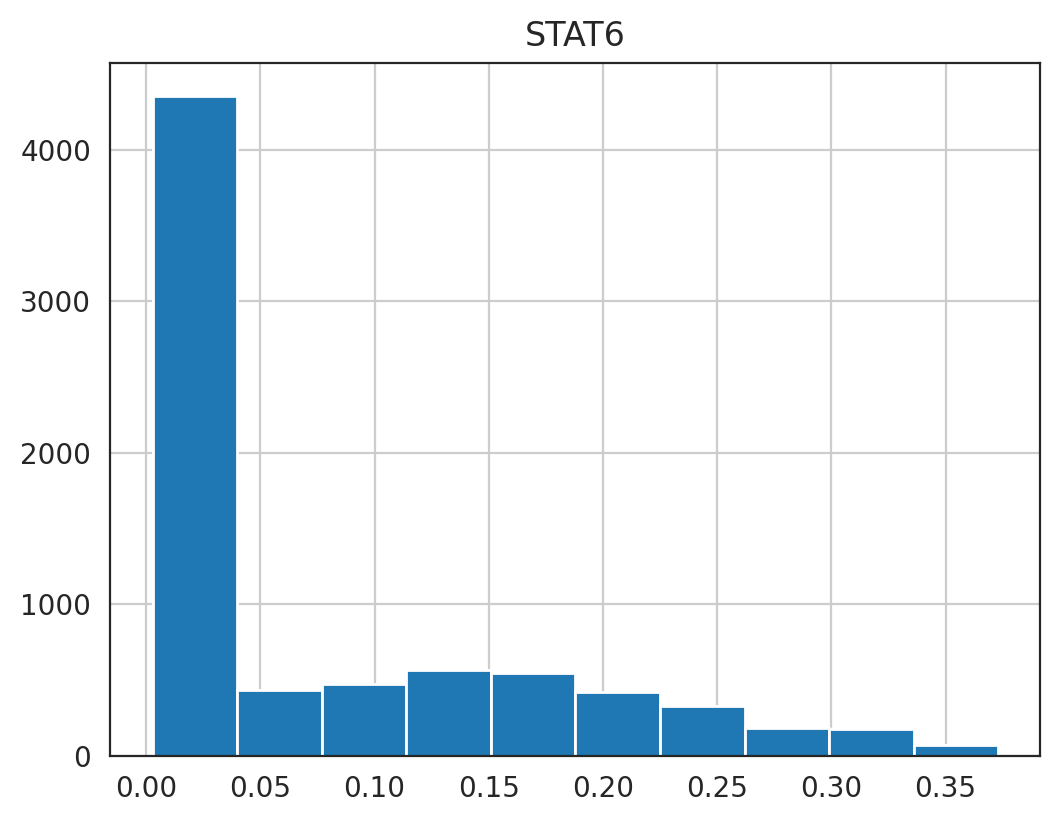

Maximum imputed expression value of STAT6: 0.37302489390347626
Perturbation expression value of STAT6: 0.7423195388679178
0.0 2.2892962763097833
[0.         0.52658903 0.74127631 0.86974169 0.95913484 1.02667203
 1.08041782 1.12474826 1.16228311 1.19470552]
Number of zero variance features: 0


In [189]:
goi = "STAT4" #Needs to match GOI in regulatory_genes
Type = "OX" #Naming convention, KO vs OX. Only for file generation
Dif_Exp_Val = 1.99 #Value between 0-2.0 for KO vs OX

output_folder = f"/mnt/c/users/UVictor/Documents/CellOracle/Shim22_GreenleafGRN/{goi}/"
os.makedirs(output_folder, exist_ok=True)


# Plot the precomputed UMAP using the imported coordinates
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name], 
           layer="imputed_count", use_raw=False, cmap="viridis")

# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

goi_imputed_values = oracle.adata[:, goi].layers["imputed_count"]
max_imputed_expression_value = goi_imputed_values.max()
print(f"Maximum imputed expression value of {goi}: {max_imputed_expression_value}")
perturb_value = max_imputed_expression_value * Dif_Exp_Val
print(f"Perturbation expression value of {goi}: {perturb_value}")

# Simulate the shift using the max imputed expression value
oracle.simulate_shift(perturb_condition={goi: (perturb_value)},
                      n_propagation=3)

print(np.min(oracle.adata.X), np.max(oracle.adata.X))
print(np.unique(oracle.adata.X)[:10])  # First 10 unique values

zero_var_features = np.where(np.var(oracle.adata.X, axis=0) == 0)[0]
print(f"Number of zero variance features: {len(zero_var_features)}")

In [190]:
oracle.estimate_transition_prob()

In [191]:
# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

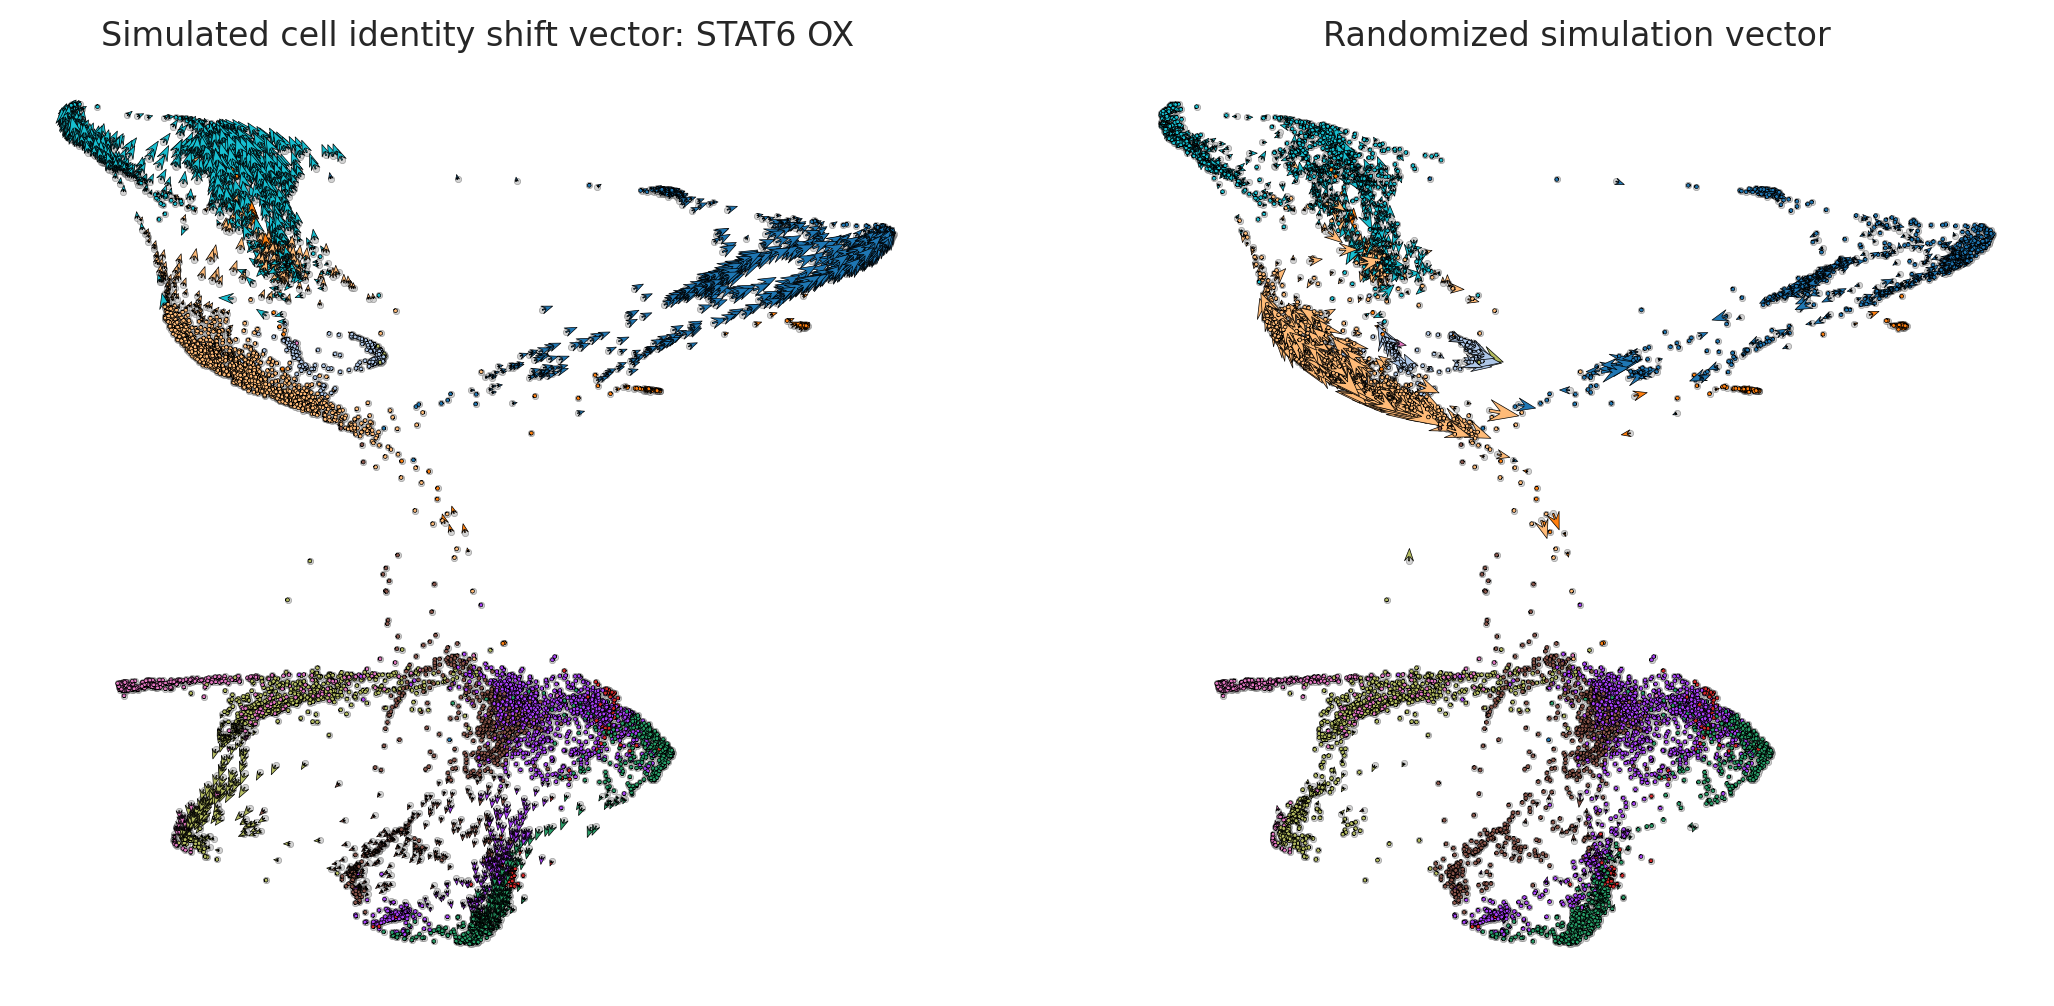

In [194]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 30
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} {Type}")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [195]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

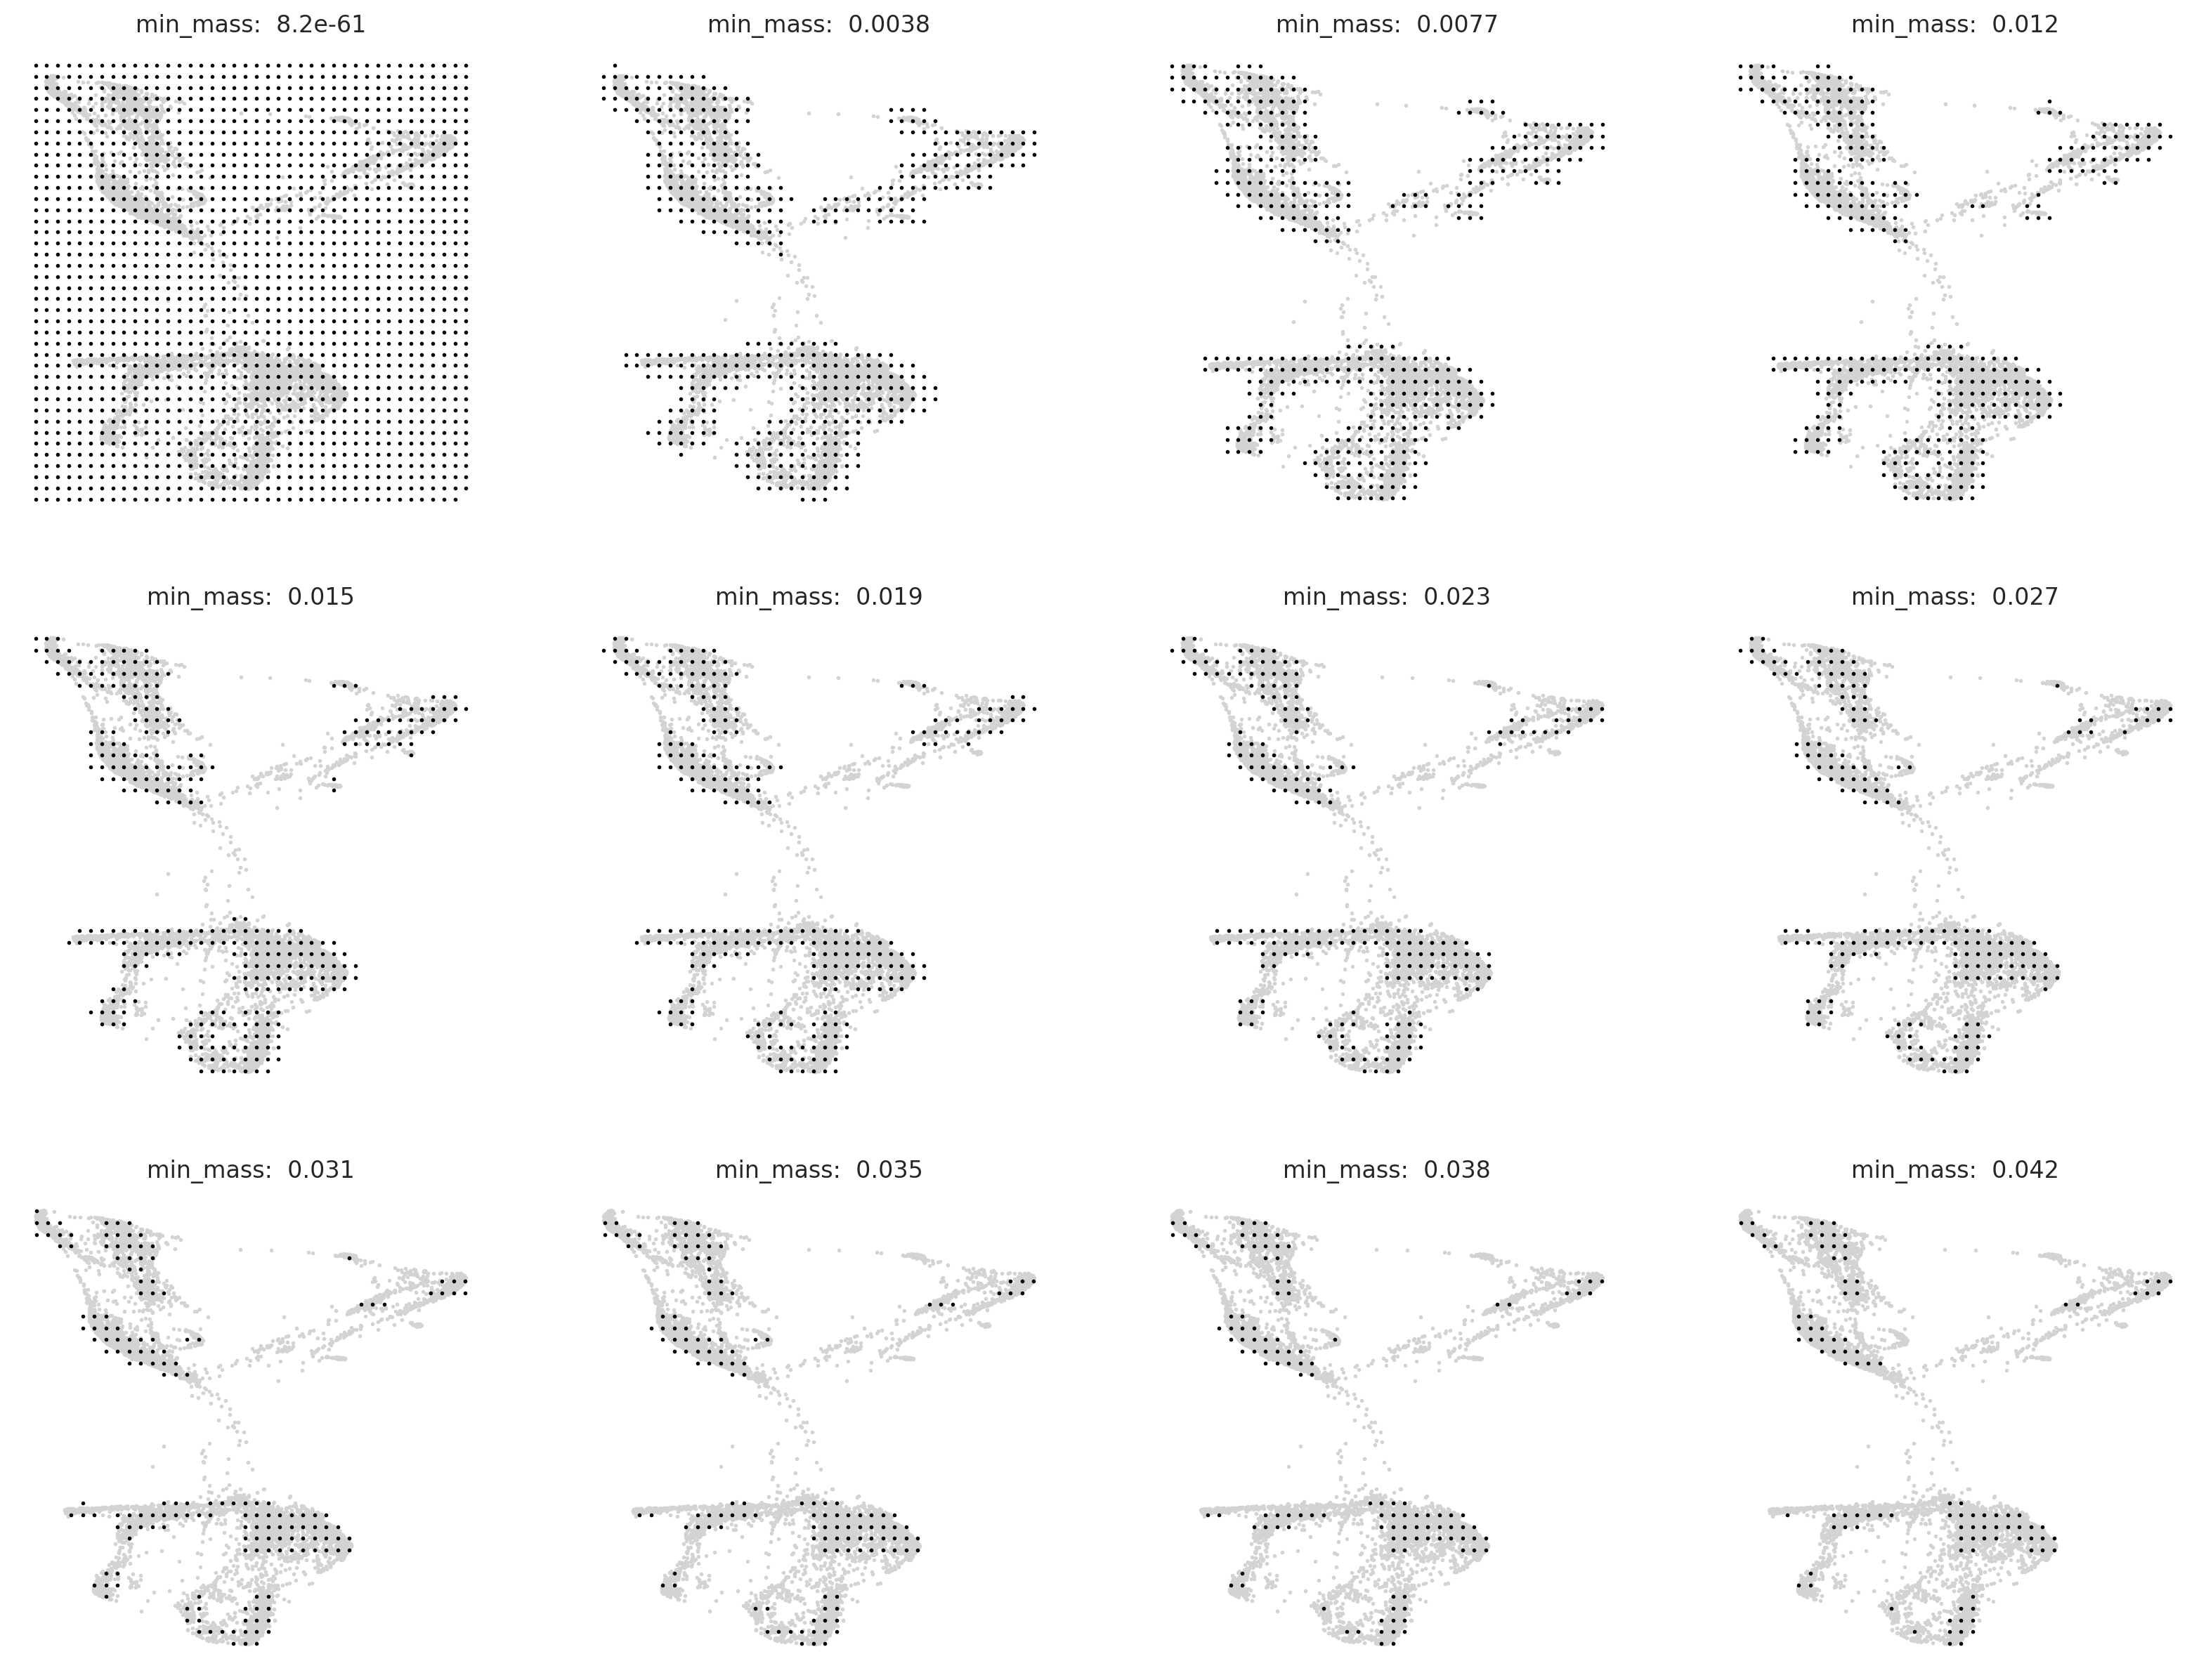

In [196]:
oracle.suggest_mass_thresholds(n_suggestion=12)

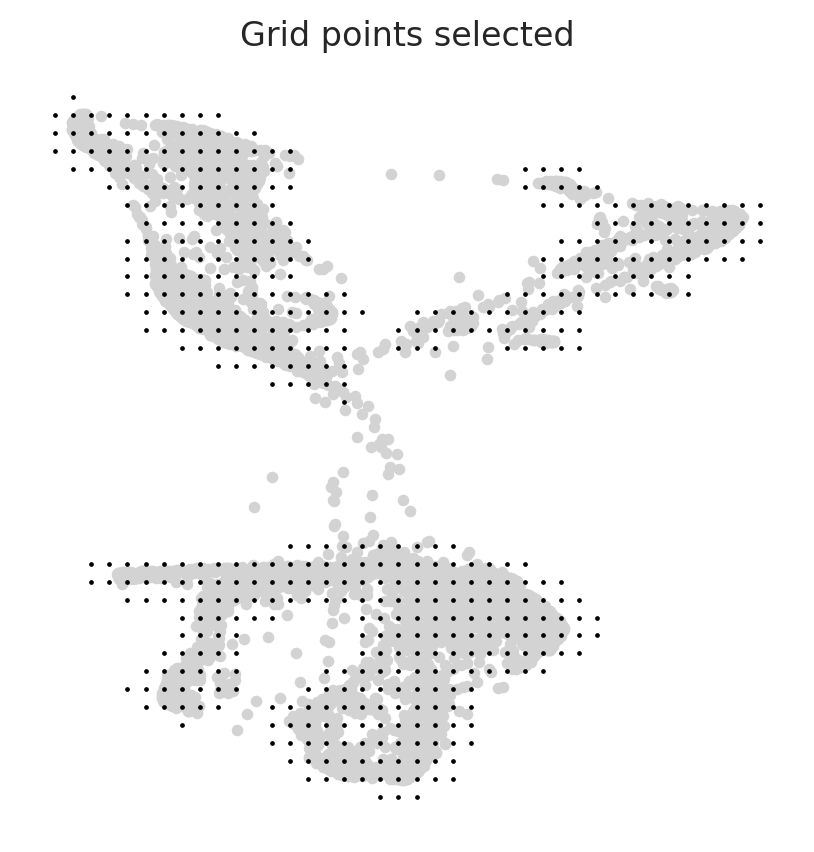

In [197]:
min_mass = 0.0038
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)



STAT6


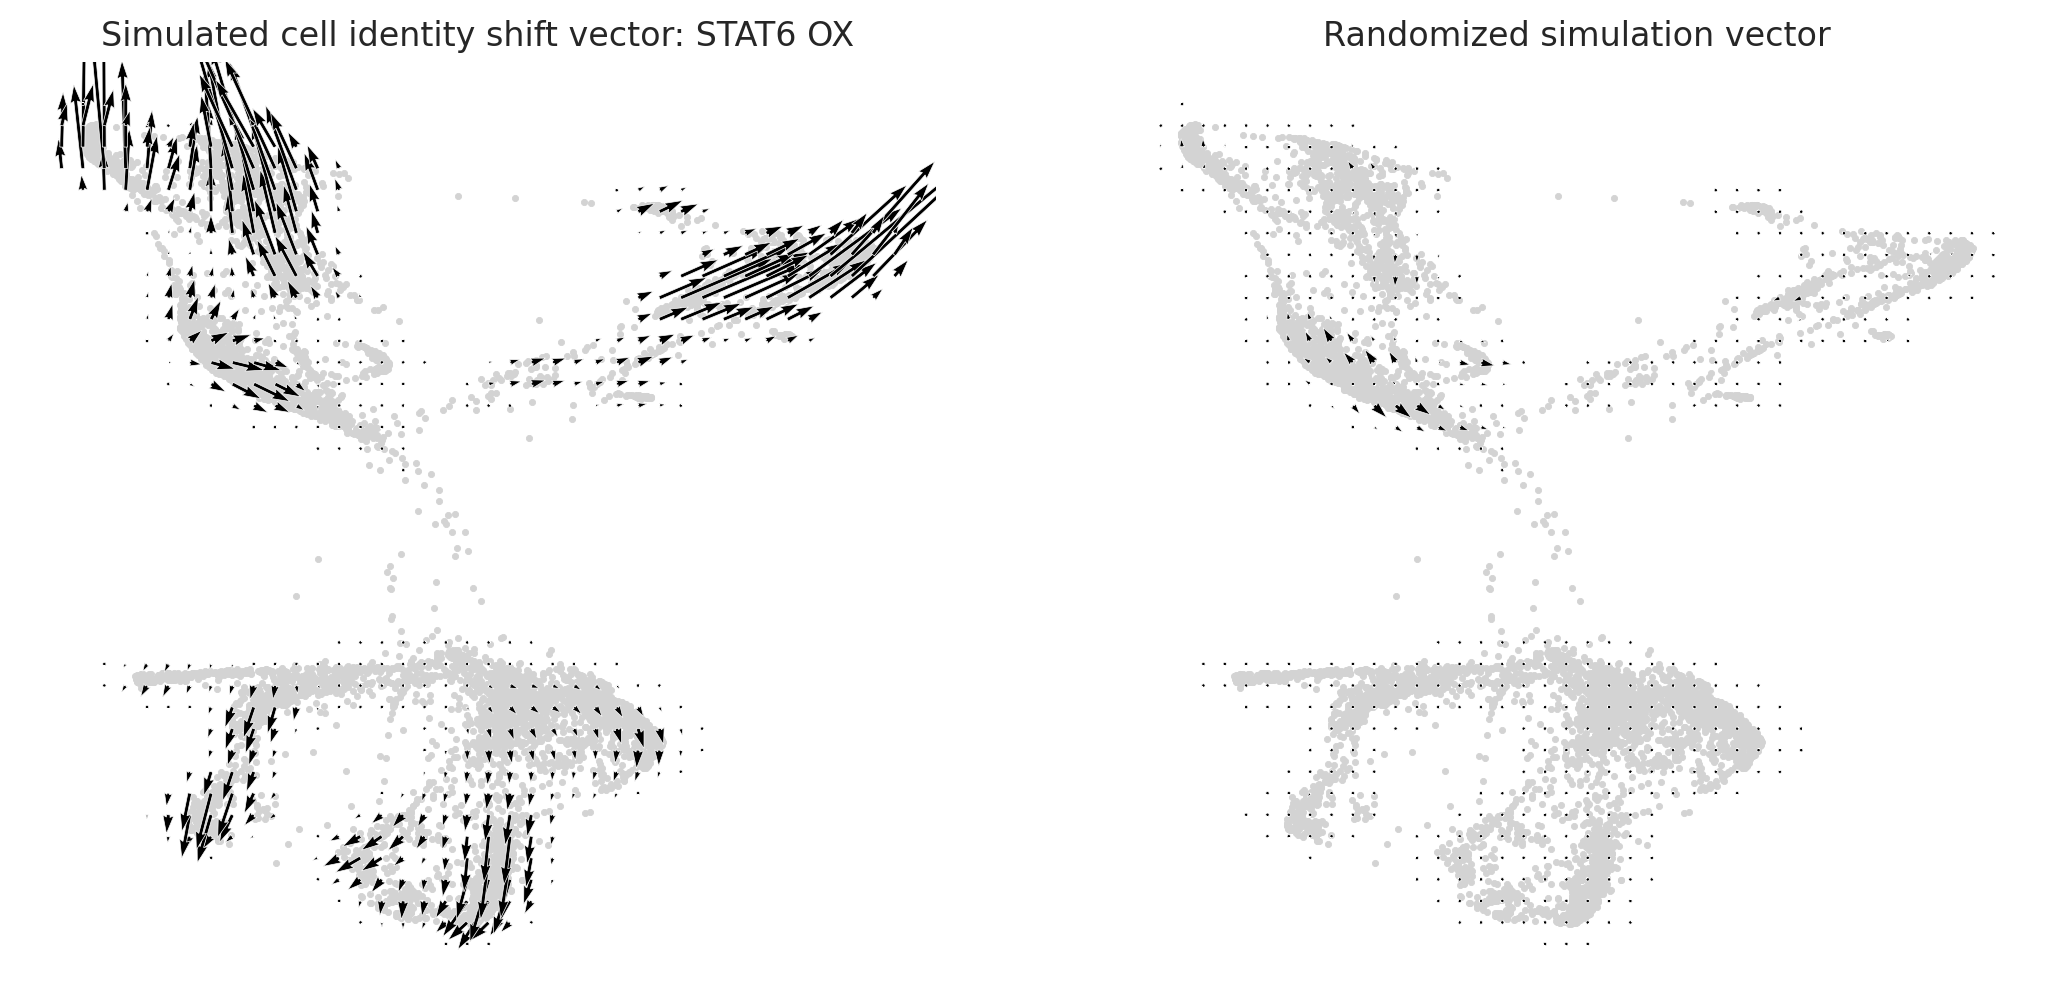

In [201]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

print(goi)

scale_simulation = 0.2
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} {Type}")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()



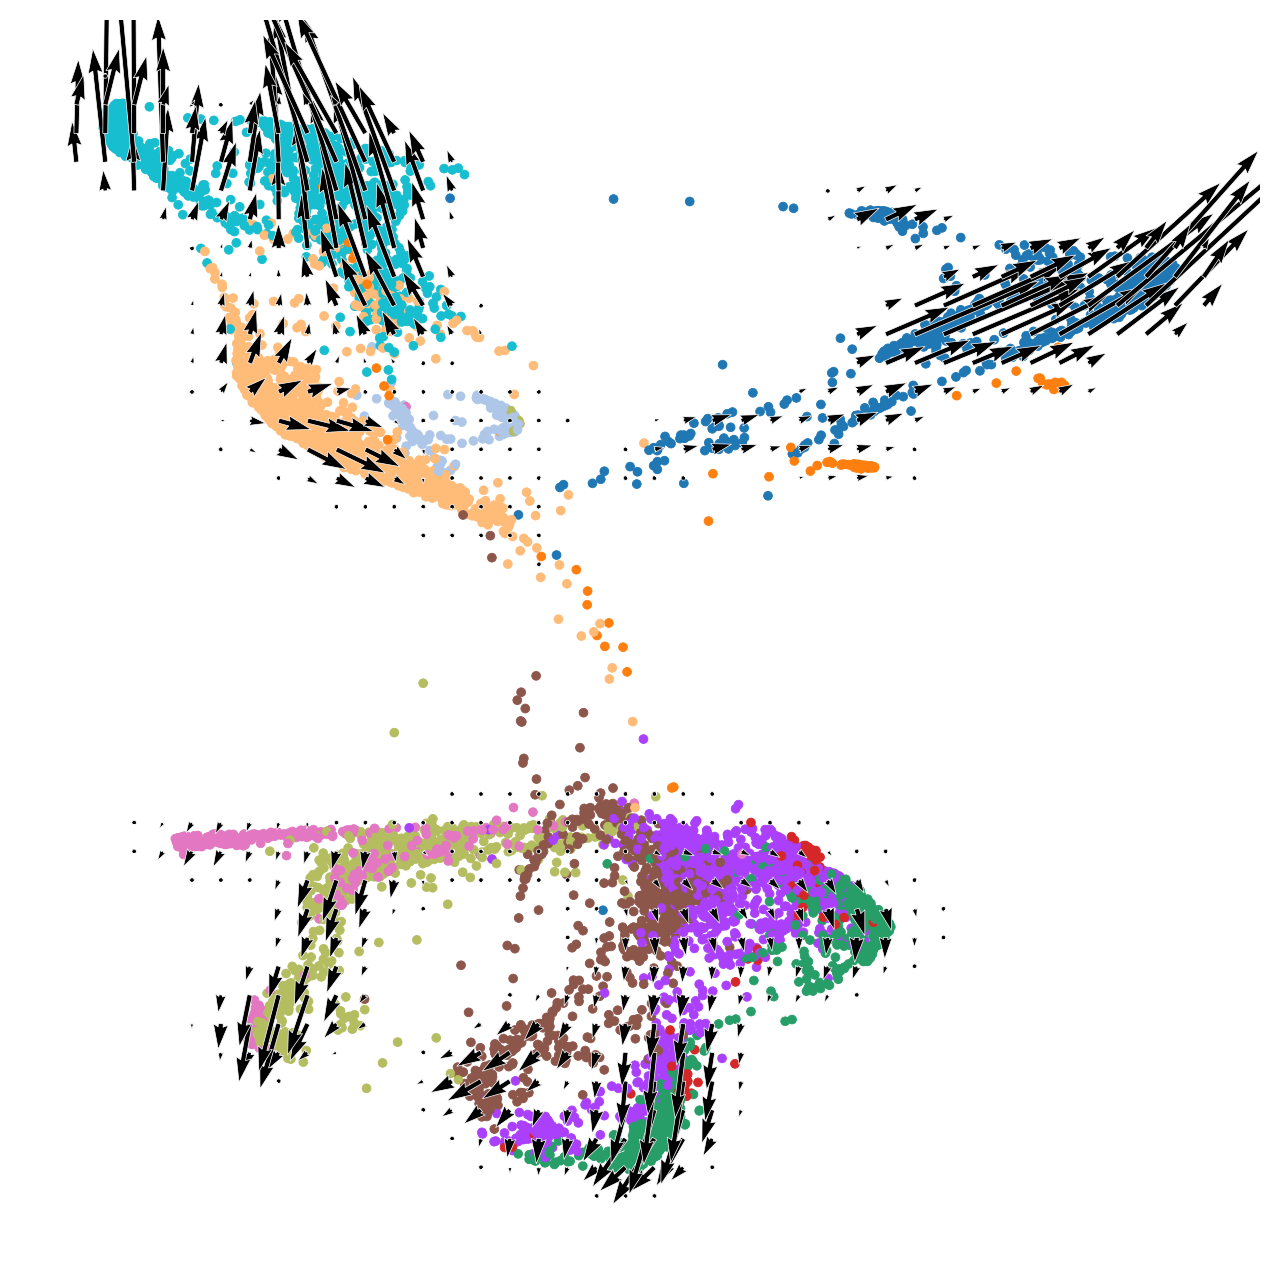

In [202]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)



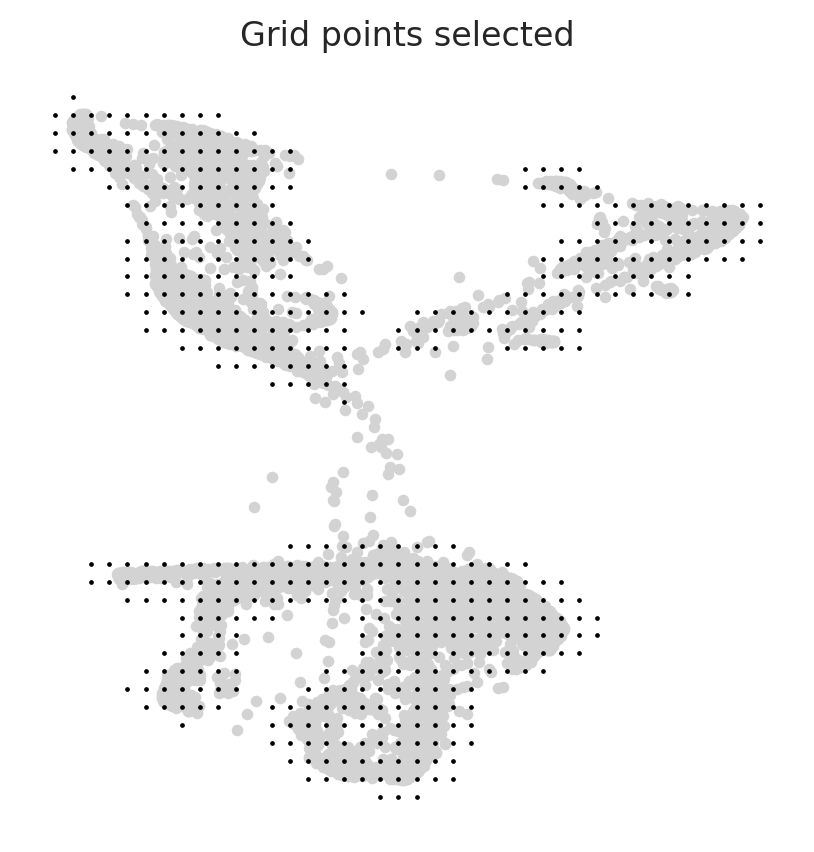

In [203]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

n_grid = 40
min_mass = 0.0038

gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)


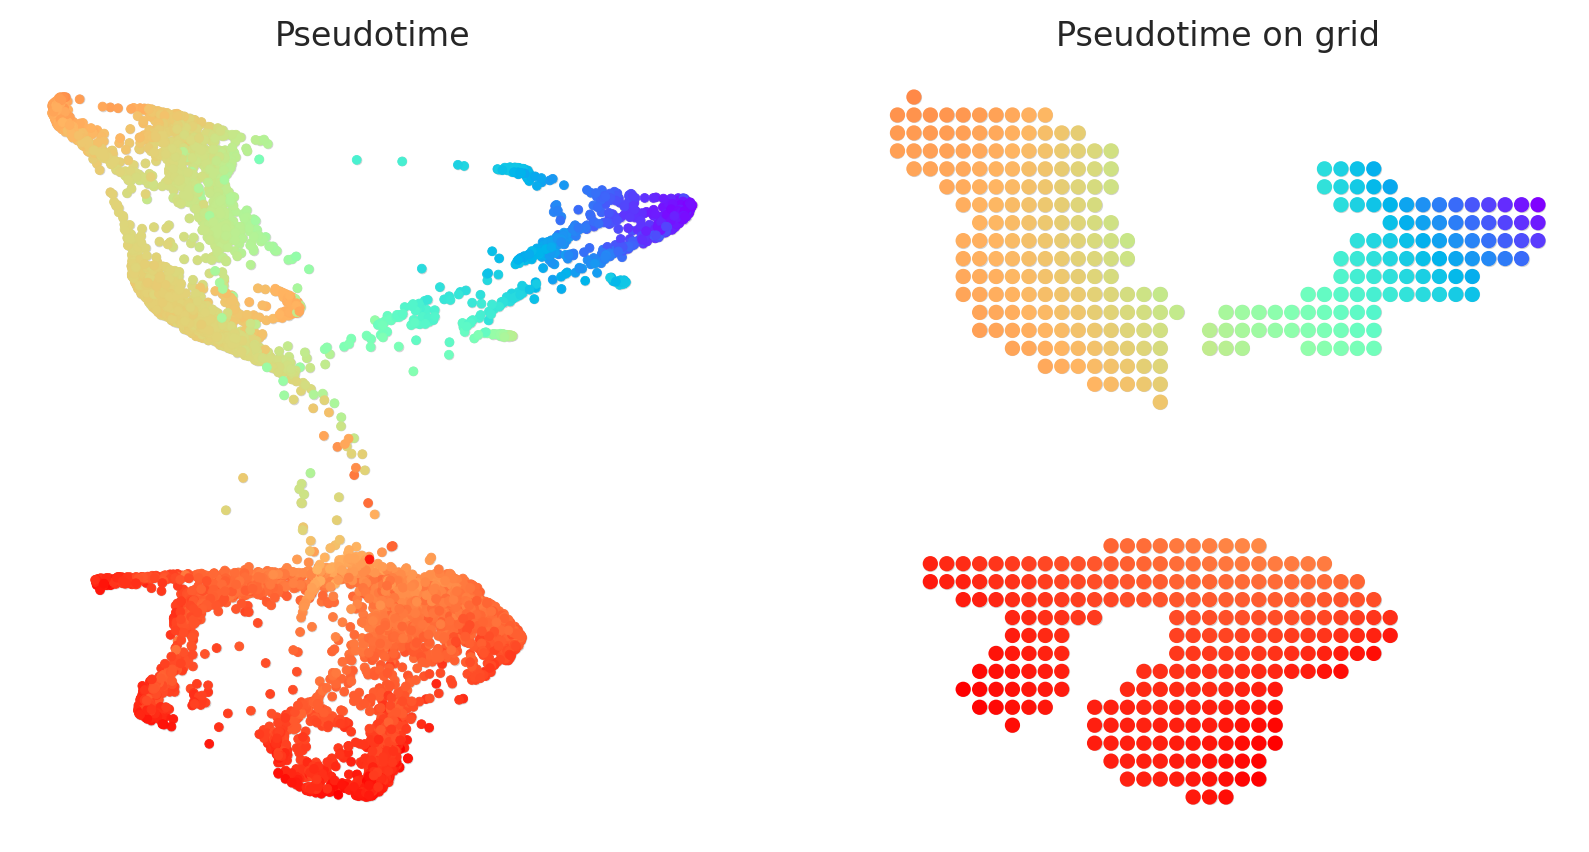

In [204]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

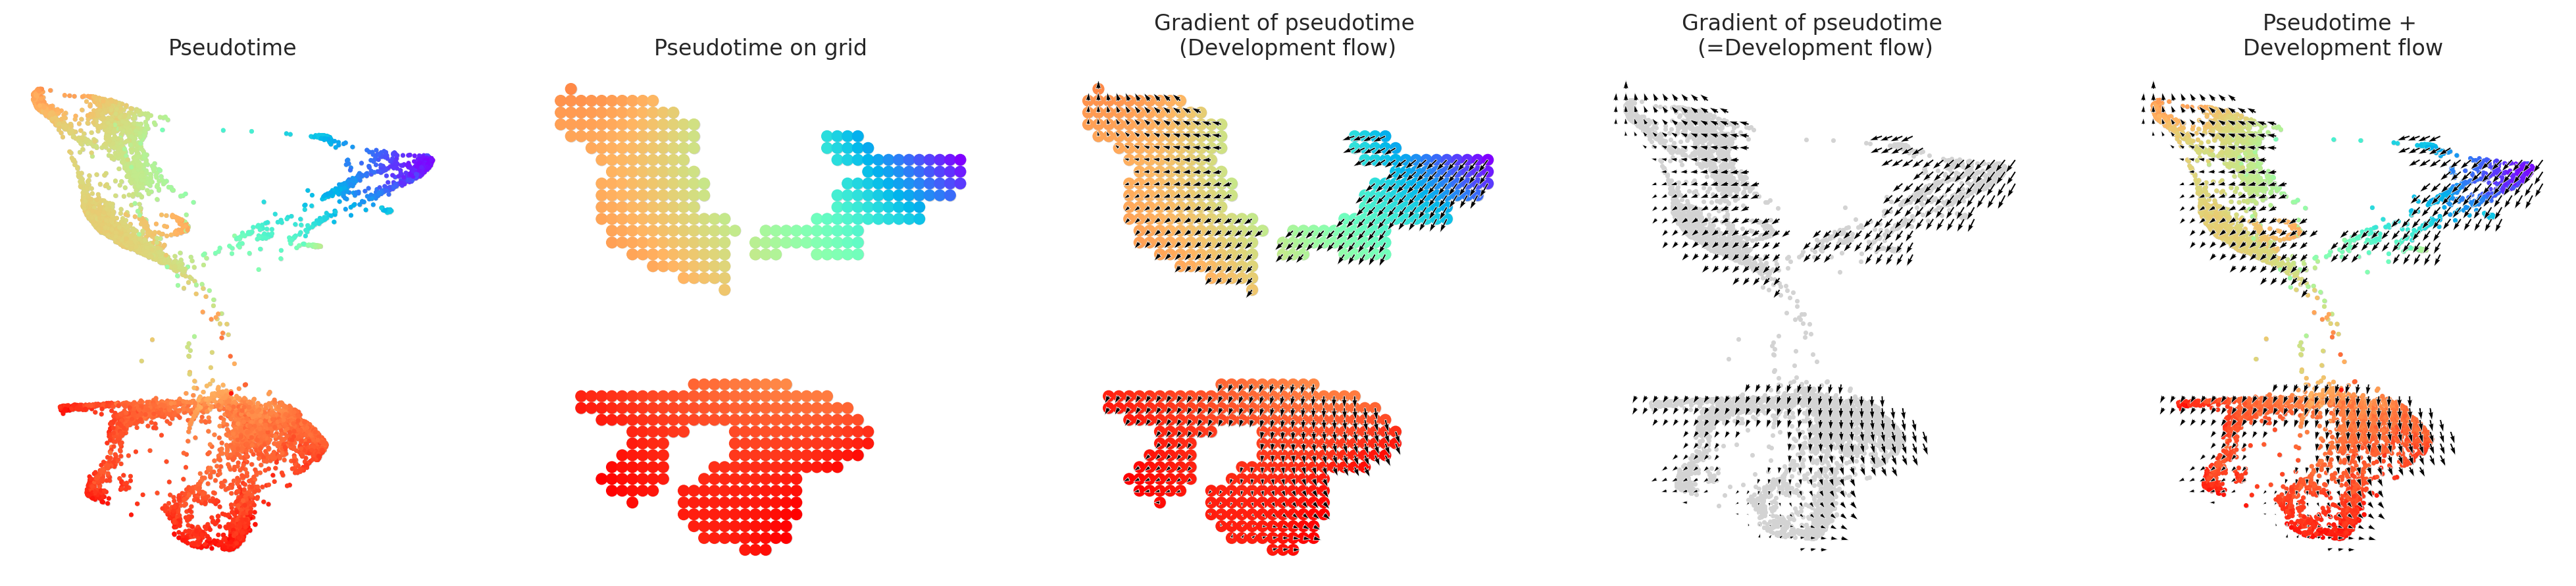

In [205]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

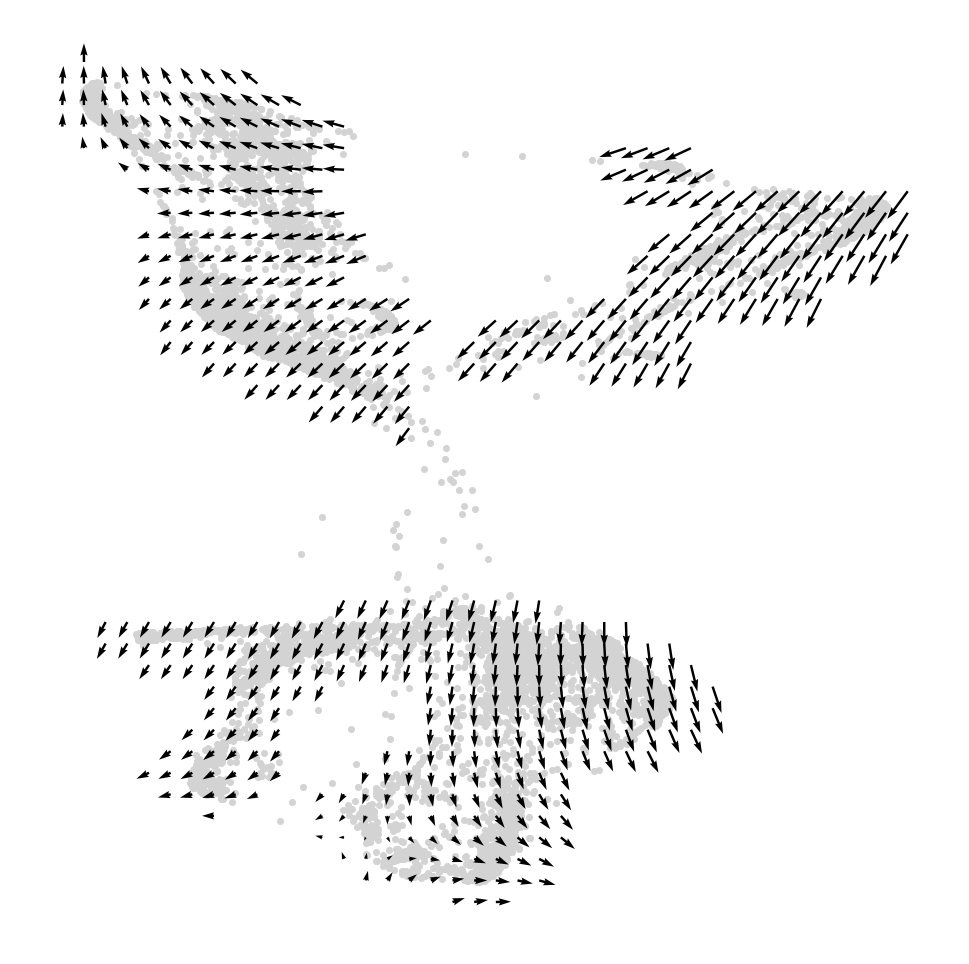

In [206]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [207]:
filename = f"Shim22_{goi}_{Type}.celloracle.gradient"

# Construct the full path
save_path = os.path.join(output_folder, filename)

# Save the gradient to the constructed HDF5 file path
gradient.to_hdf5(save_path)

In [208]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

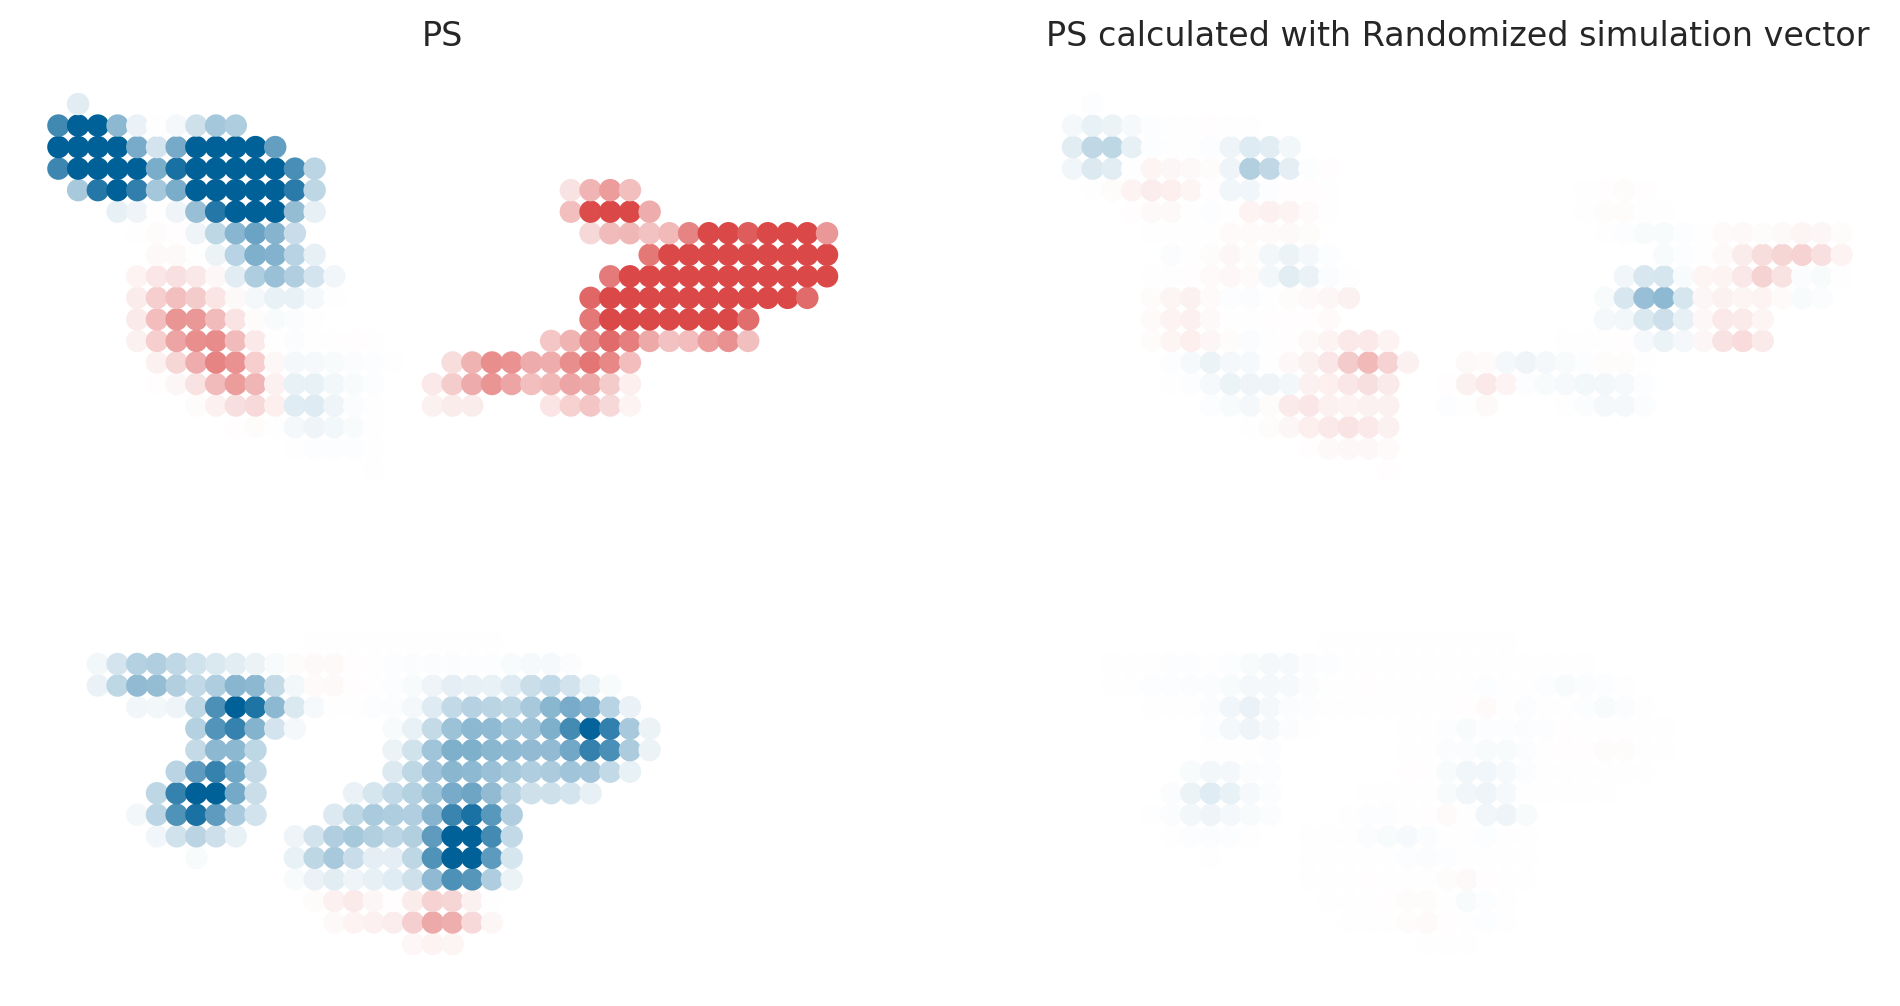

In [209]:
from matplotlib.colors import LinearSegmentedColormap
from celloracle.visualizations.config import CONFIG

# Define your custom colors with hex codes, including white in the middle
custom_colors = ["#DA4948", "#FFFFFF", "#006199"]  # Red, White, Blue

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Set the colormap in the CellOracle CONFIG
CONFIG["cmap_ps"] = custom_cmap

# Show perturbation scores
vm = 0.005

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm= vm, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

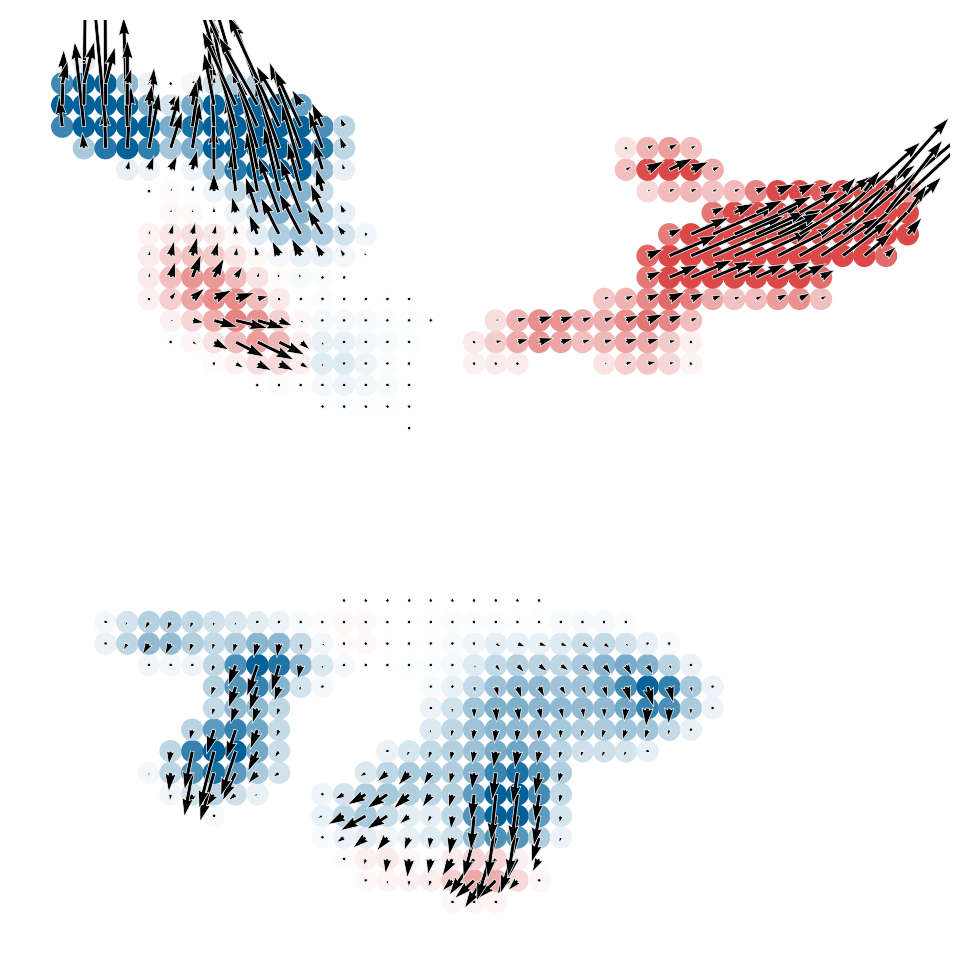

In [210]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

file_name = f"{goi}_{Type}_overview_layout.png"
file_path = f"{output_folder}/{file_name}"
plt.savefig(file_path, format='png', dpi=600)

2024-10-21 19:59:07,865 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-21 19:59:07,875 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


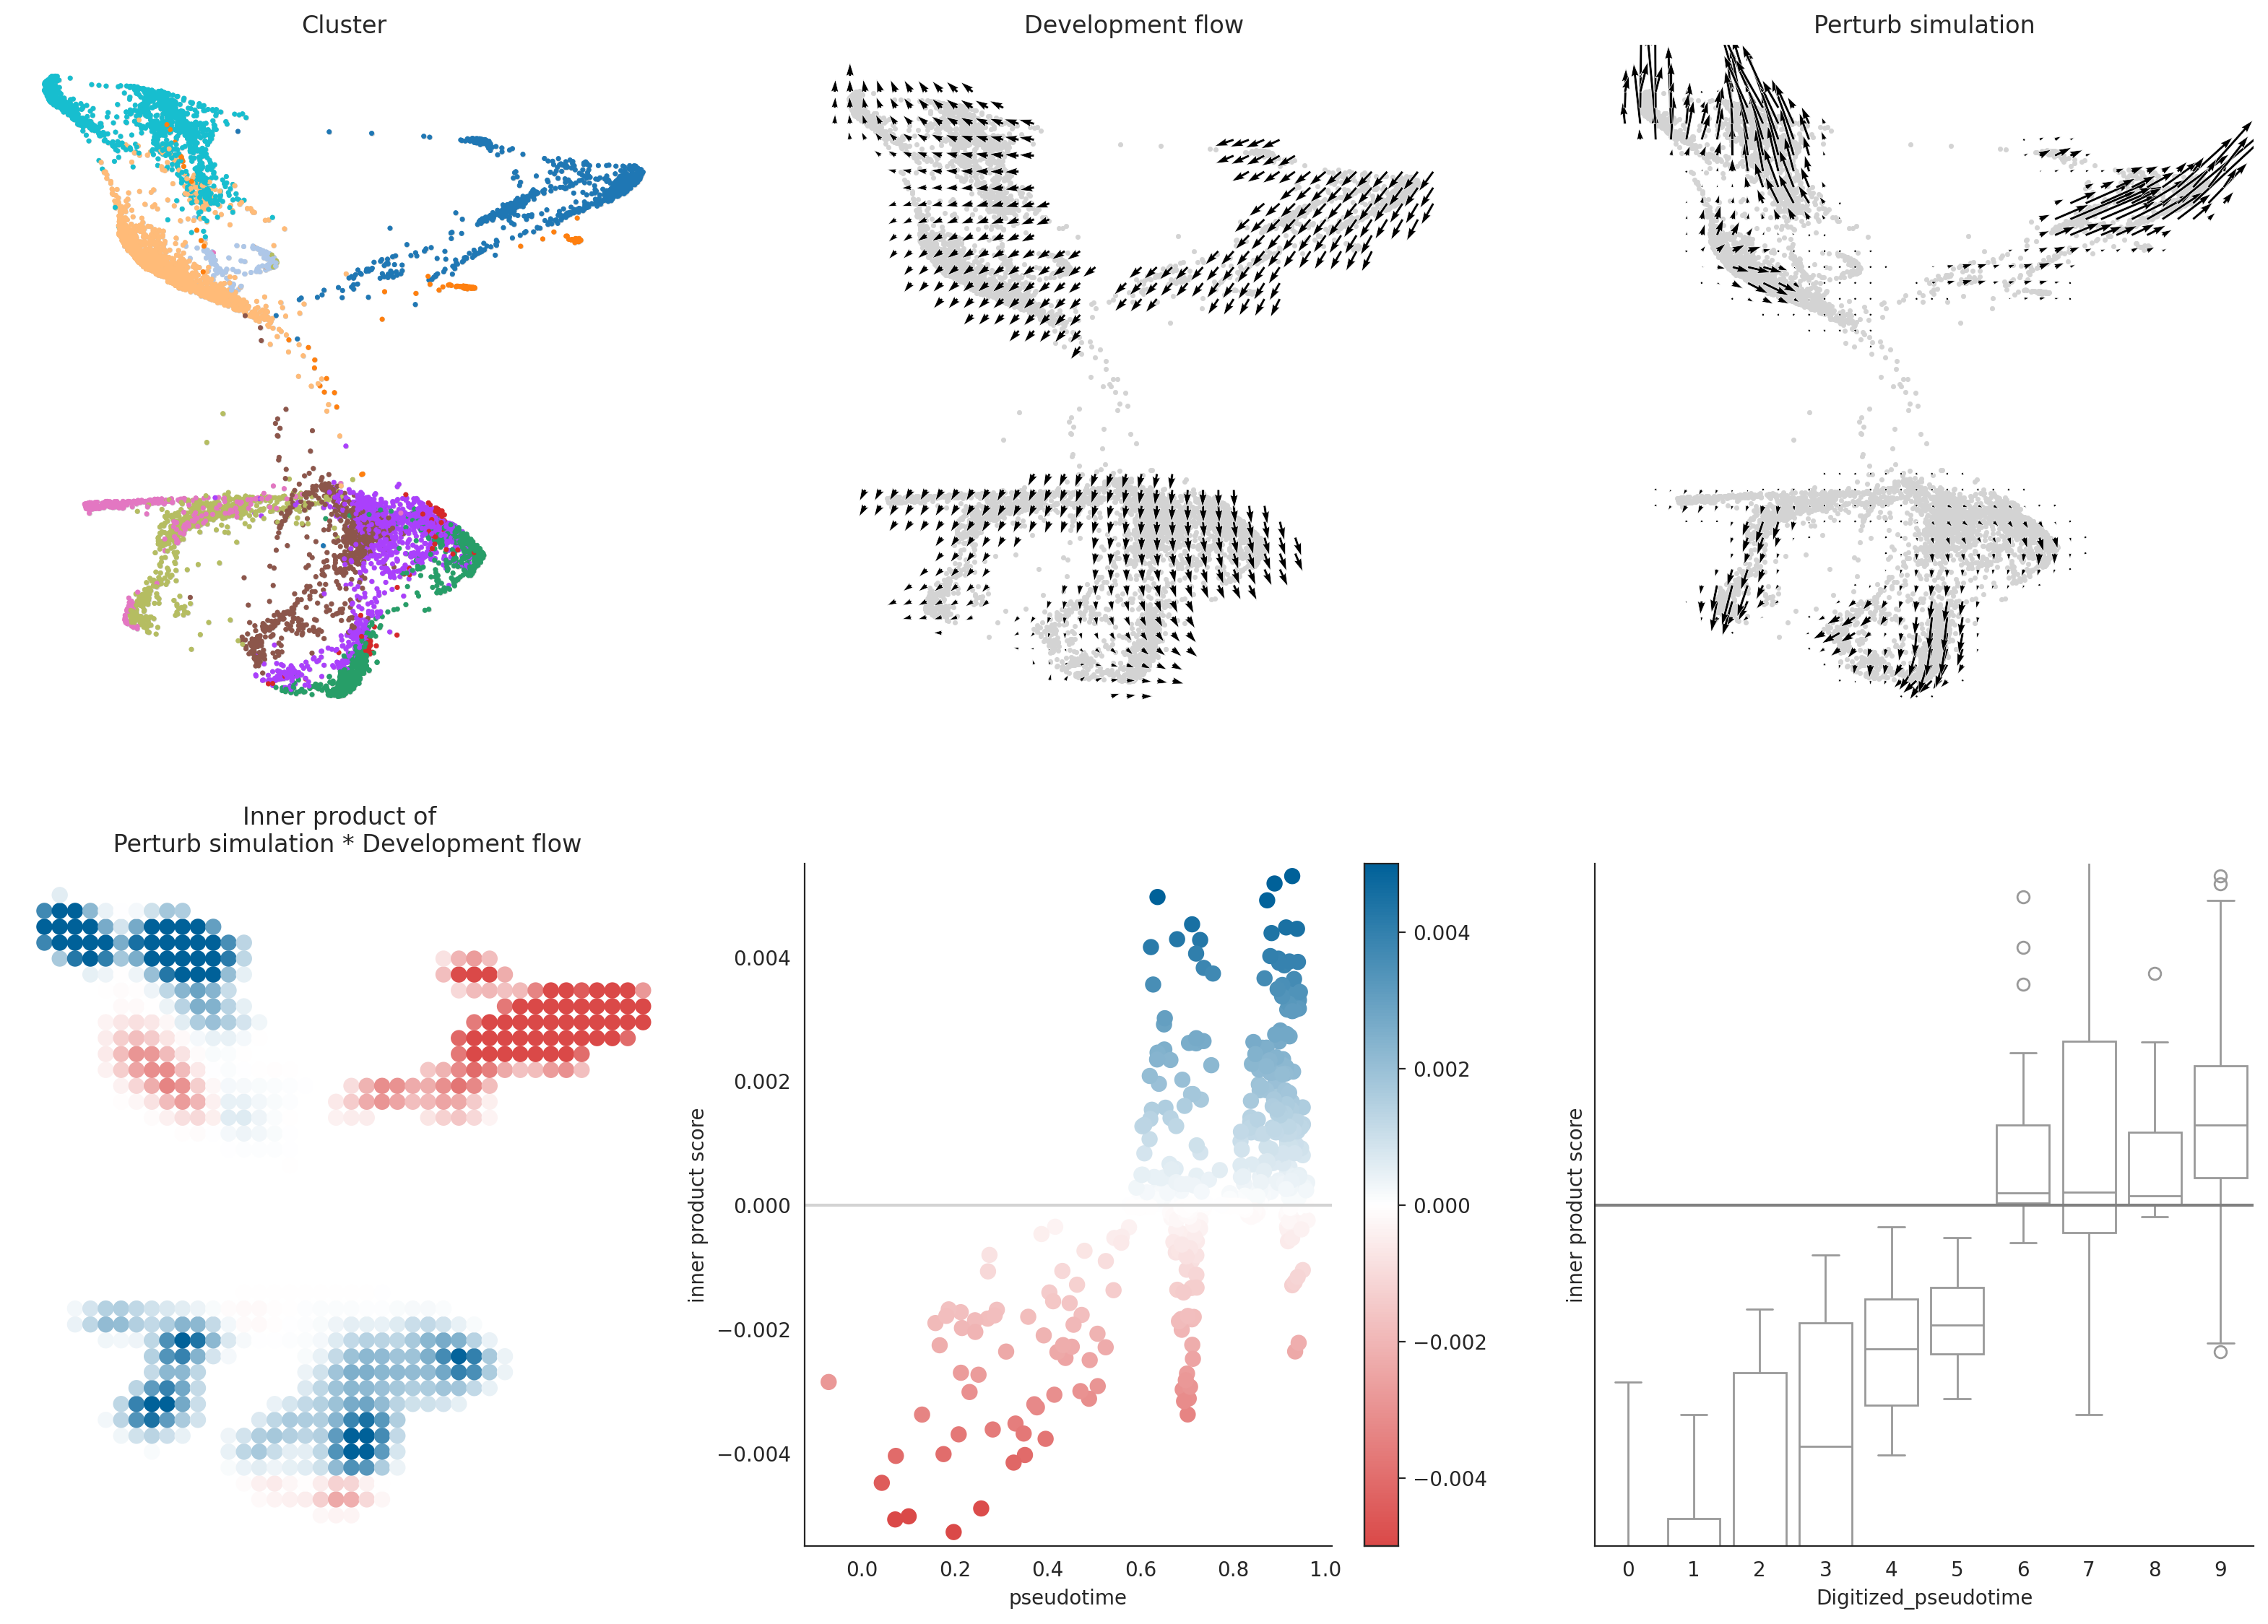

In [211]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=vm)

file_name = f"{goi}_{Type}_development_module_layout.png"
file_path = f"{output_folder}/{file_name}"
plt.savefig(file_path, format='png', dpi=600)